# Linking field data to imagery to update the Fractional Cover and Ground Cover Models
This is the workbook used to compute the new end-to-end fractional cover model


## Imports

In [53]:
# Imports
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import datetime
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, regularizers
from tensorflow.keras.constraints import max_norm



print("TensorFlow v"+tf.__version__)
print(tf.test.gpu_device_name())



TensorFlow v2.3.0



## Read field and image data

All field data sits on postgres linked to ODK field data capture system.  
Need to first link view below the canopy to view above the canopy.  


In [54]:
CALIBRATION_DATA = '../fielddata/fractionalChips20181204.csv'

# Function to convert a date to a timestamp
def datestr2num(s):
    return (datetime.datetime.strptime(s,'%d/%m/%Y') - datetime.datetime(1970, 1, 1)).total_seconds()

# Function to get the sensor number (Landsat 5, 7 or 8) from a JRSRP filename
def sensorNum(s):
    return float(s[1])


interceptData = pd.read_csv(CALIBRATION_DATA,
                        na_values = "nan",
                        sep=",",
                        skipinitialspace=True).sample(frac=1)

# Add timestamp and sensor number to the dataframe
interceptData['fractional.obs_timestamp'] = interceptData['fractional.obs_time'].apply(datestr2num)
interceptData['fractional.obs_sensornum'] = interceptData['fractional_chips.filename'].apply(sensorNum)

# Load Reflectance Data fromthe closest point in time
refData = np.array(interceptData[['fractional_chips.b1_sf_mn',
       'fractional_chips.b2_sf_mn', 'fractional_chips.b3_sf_mn',
       'fractional_chips.b4_sf_mn', 'fractional_chips.b5_sf_mn',
       'fractional_chips.b6_sf_mn']]) / 10000.0

# Convert L8 to L7 so the model is in Landsat 7 spectral space
l8Idx=interceptData['fractional.obs_sensornum']>7
print ("There are %d Landsat 8 Scenes" % sum(l8Idx))

# Use the published coefficients to transform reflectance
refData[l8Idx] = refData[l8Idx] * (
    np.array([0.97470, 0.99779, 1.00446, 0.98906, 0.99467, 1.02551]) + 
    np.array([0.00041, 0.00289, 0.00274, 0.00004, 0.00256, -0.00327])
)

# Drop out the Blue Band
refData = refData[:,1:]


There are 1272 Landsat 8 Scenes


### Function to load the calibration data and return the satellite viewable components 

In [55]:
def fractionalCoverSatView(interceptData):
    nTotal = interceptData['fractional.num_points']
    nUnoccluded = interceptData['fractional.unoccluded']
    # Canopy Layer
    nCanopyBranch = interceptData['fractional.over_b'] * nTotal / 100.0
    nCanopyDead = interceptData['fractional.over_d'] * nTotal / 100.0
    nCanopyGreen = interceptData['fractional.over_g'] * nTotal / 100.0
    nCrown = interceptData['fractional.crn']
    # Midstory Layer
    nMidBranch = interceptData['fractional.mid_b'] * nTotal / 100.0
    nMidGreen = interceptData['fractional.mid_g'] * nTotal / 100.0
    nMidDead = interceptData['fractional.mid_d'] * nTotal / 100.0
    # Ground Layer
    nGroundDeadLitter = (interceptData['fractional.dead'] + interceptData['fractional.litter']) * nUnoccluded / 100.0
    nGroundCrustDistRock = (interceptData['fractional.crust'] + interceptData['fractional.dist'] + interceptData['fractional.rock']) * nUnoccluded / 100.0
    nGroundGreen = interceptData['fractional.green'] * nUnoccluded / 100.0
    nGroundCrypto = interceptData['fractional.crypto'] * nUnoccluded / 100.0
    # Work out the canopy elements as viewed from above
    canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
    canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
    canopyBranchProjectiveCover = nCanopyBranch / nTotal * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
    canopyPlantProjectiveCover = (nCanopyGreen+nCanopyDead + nCanopyBranch) / nTotal
    # Work out the midstorey fractions
    midFoliageProjectiveCover = nMidGreen / nTotal
    midDeadProjectiveCover = nMidDead / nTotal
    midBranchProjectiveCover = nMidBranch / nTotal
    midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal
    # Work out the midstorey  elements as viewed by the satellite using a gap fraction method
    satMidFoliageProjectiveCover = midFoliageProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidDeadProjectiveCover = midDeadProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidBranchProjectiveCover = midBranchProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidPlantProjectiveCover = midPlantProjectiveCover * (1 - canopyPlantProjectiveCover)
    # Work out the groundcover fractions as seen by the observer
    groundPVCover = nGroundGreen / nUnoccluded
    groundNPVCover = nGroundDeadLitter / nUnoccluded
    groundBareCover = nGroundCrustDistRock / nUnoccluded
    groundCryptoCover = nGroundCrypto / nUnoccluded
    groundTotalCover = (nGroundGreen + nGroundDeadLitter + nGroundCrustDistRock) / nUnoccluded
    # Work out the ground cover propoetions as seen by the satellite
    satGroundPVCover = groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundNPVCover = groundNPVCover * ( 1- midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundBareCover = groundBareCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundCryptoCover = groundCryptoCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundTotalCover = groundTotalCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    # Final total covers calculated using gap probabilities through all layers
    totalPVCover = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
    totalNPVCover = canopyDeadProjectiveCover + canopyBranchProjectiveCover + satMidDeadProjectiveCover + satMidBranchProjectiveCover + satGroundNPVCover
    totalBareCover = satGroundBareCover
    totalCryptoCover = satGroundCryptoCover
    # Work Out Persistent Fractions
    satPersistentGreen=canopyFoliageProjectiveCover+satMidFoliageProjectiveCover
    persistentNPVFraction=canopyDeadProjectiveCover+canopyBranchProjectiveCover+satMidDeadProjectiveCover+satMidBranchProjectiveCover

    return (totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction)
    
totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction = fractionalCoverSatView(interceptData)

print  ("Number of sites: %d" % len(totalPVCover))



Number of sites: 4000


## Iteration 1 - Minimal Prediction to assign crypto and pick up color errors
The next problem to address is field labeling issues.  
First, cryptogram (or biological soil crusts) are not assigned a "colour" and we need to decide whether to treat them as green or non green. We do this by doing a rough model fit, and then testing where the cryptogram component for each sit best fits.  
There is also an observer bias issue, where in areas of "yellow" grass people will pick non-green or green for the entire site. We check for this by looking for sites with a good bare fit but with a large and opposite error term for the green and non-green. By iterativly adjusting the field estimates across classes we gradually improve the bare estimate.  

In [57]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

# Build the training Labels
train_labels = np.transpose([totalBareCover,totalPVCover,totalNPVCover])
train_dataset = refData.copy()



model = keras.Sequential([
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3),input_shape=[train_dataset.shape[1]]),
layers.Dense(64, activation='relu', kernel_constraint=max_norm(3)),
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3)),
layers.Dense(3)
])

model.compile(loss='huber_loss', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Fit the Model 
history = model.fit(train_dataset, train_labels,
                    epochs=10000,
                    validation_split = 0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=4096,
                    callbacks=[early_stop,PrintDot()])

allPredictions = model.predict(train_dataset)
predNongreenCover=allPredictions[:,2]
predGreenCover=allPredictions[:,1]
predBareCover=allPredictions[:,0]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### Guess the cryptogram class by assigning to the class that gives the best fit

In [58]:

# Assign the crypto to the class that improves the error the most    
greenError  = predGreenCover - totalPVCover
nongreenError = predNongreenCover-totalNPVCover

cryptoNongreenIDX = (np.abs(nongreenError) >= np.abs(nongreenError-totalCryptoCover))
cryptoGreenIDX = (np.abs(nongreenError) < np.abs(nongreenError-totalCryptoCover))
totalPVCover[cryptoGreenIDX] = totalPVCover[cryptoGreenIDX] + totalCryptoCover[cryptoGreenIDX]
totalNPVCover[cryptoNongreenIDX] = totalNPVCover[cryptoNongreenIDX] + totalCryptoCover[cryptoNongreenIDX]


print("Nongreen crypto samples = %f" %np.sum(cryptoNongreenIDX))
print("Green crypto samples = %f" %np.sum(cryptoGreenIDX))



Nongreen crypto samples = 3380.000000
Green crypto samples = 620.000000


### Fix the errors
Once we have candidate models built we can check for mislabeled fractions and then assign the cryptogram.  
Note that is's only 10 or so sites that need cover label  repair.  

In [59]:
errorChange=1.0
error=10.0
siteList=[]

while errorChange > 0.0001:
    greenError  = predGreenCover - totalPVCover
    nongreenError = predNongreenCover-totalNPVCover
    bigOpposite = np.abs(greenError - nongreenError)
    bigIDX = np.argmax(bigOpposite)
    siteList.append(bigIDX)
    errorChange = error - bigOpposite[bigIDX]
    error = bigOpposite[bigIDX]
    print ("Max error = %f in site %d with total sites changed = %d" % (error,bigIDX,len(np.unique(siteList))))
    adjustment = (totalPVCover[bigIDX]+totalNPVCover[bigIDX])/100.0
    if  (greenError[bigIDX] > nongreenError[bigIDX]):
        totalNPVCover[bigIDX] = totalNPVCover[bigIDX] - np.min([adjustment,totalNPVCover[bigIDX]])
        totalPVCover[bigIDX] = totalPVCover[bigIDX] + np.min([adjustment,totalNPVCover[bigIDX]])

    else:
        totalPVCover[bigIDX] = totalPVCover[bigIDX] - np.min([adjustment,totalPVCover[bigIDX]])
        totalNPVCover[bigIDX] = totalNPVCover[bigIDX] + np.min([adjustment,totalPVCover[bigIDX]])

    
print("New green RMSE = %f" % np.sqrt(np.mean((totalPVCover-predGreenCover)**2)))
print("New nongreen RMSE = %f" % np.sqrt(np.mean((totalNPVCover-predNongreenCover)**2)))

print(np.unique(siteList))

Max error = 0.187721 in site 2152 with total sites changed = 1
Max error = 0.178928 in site 2152 with total sites changed = 1
Max error = 0.170135 in site 2152 with total sites changed = 1
Max error = 0.161341 in site 2152 with total sites changed = 1
Max error = 0.152548 in site 2152 with total sites changed = 1
Max error = 0.143755 in site 2152 with total sites changed = 1
Max error = 0.134962 in site 2152 with total sites changed = 1
Max error = 0.126169 in site 2152 with total sites changed = 1
Max error = 0.117375 in site 2152 with total sites changed = 1
Max error = 0.108582 in site 2152 with total sites changed = 1
Max error = 0.099789 in site 2152 with total sites changed = 1
Max error = 0.090996 in site 2152 with total sites changed = 1
Max error = 0.082203 in site 2152 with total sites changed = 1
Max error = 0.073410 in site 2152 with total sites changed = 1
Max error = 0.064616 in site 2152 with total sites changed = 1
Max error = 0.055823 in site 2152 with total sites chan

## Generate the updated training labels

In [60]:
# Find any wild outliers - Typically early CHAT sites
isNotOutlierIDX = np.where(np.abs(totalBareCover-predBareCover) < 0.4)
print(len(isNotOutlierIDX[0]))
totalBareCover = np.array(totalBareCover)[isNotOutlierIDX]
totalPVCover = np.array(totalPVCover)[isNotOutlierIDX]
totalNPVCover = np.array(totalNPVCover)[isNotOutlierIDX]
refData = refData[isNotOutlierIDX]


3958


## Equal Sampling Weighting
Because the samples are not uniformly distributed across the cover space, we set up a histogram based weighting function to make sure those rare sites still contribute to the model.

[2.5202759620708757, -2.8397707979351643, 0.9178883973351432, -0.041639053919259914]
[0.22101840163661096, 0.03365249422442333, 0.056147663985613695, 0.005758386270465495]
[-0.5318549967898122, 1.417962846401424, -0.9948129576584963, 0.2582327628522405]


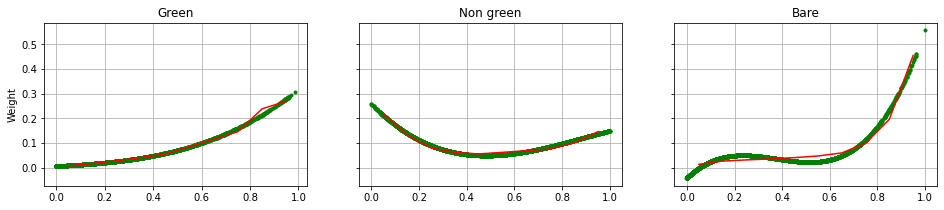

In [61]:
# Weighting by number of points
histoB = np.histogram(totalBareCover,bins=10,range=[0,1])
histoNormB=histoB[0].sum()/histoB[0]
histoNormB /= histoNormB.sum()
bareCoeffs = np.polyfit((histoB[1][1:]+histoB[1][:-1])/2,histoNormB,3)
print(list(bareCoeffs))
bareWeights = np.polyval(bareCoeffs,totalBareCover)

# Weighting by number of points
histoG = np.histogram(totalPVCover,bins=10,range=[0,1])
histoNormG=histoG[0].sum()/histoG[0]
histoNormG /= histoNormG.sum()
greenCoeffs = np.polyfit((histoG[1][1:]+histoG[1][:-1])/2,histoNormG,3)
print(list(greenCoeffs))
greenWeights = np.polyval(greenCoeffs,totalPVCover)

# Weighting by number of points
histoN = np.histogram(totalNPVCover,bins=10,range=[0,1])
histoNormN=histoN[0].sum()/histoN[0]
histoNormN /= histoNormN.sum()
nonGreenCoeffs = np.polyfit((histoN[1][1:]+histoN[1][:-1])/2,histoNormN,3)
print(list(nonGreenCoeffs))
nonGreenWeights = np.polyval(nonGreenCoeffs,totalNPVCover)

sampleWeights = np.transpose([bareWeights,greenWeights,nonGreenWeights])

# Initialise the 1 row 3 column plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,3),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,greenWeights,'g.',(histoG[1][1:]+histoG[1][:-1])/2,histoNormG, 'r-')
ax2.plot(totalNPVCover,nonGreenWeights,'g.',(histoN[1][1:]+histoN[1][:-1])/2,histoNormN, 'r-')
ax3.plot(totalBareCover,bareWeights,'g.',(histoB[1][1:]+histoB[1][:-1])/2,histoNormB, 'r-')
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green')
ax2.set_title('Non green')
ax3.set_title('Bare')
ax1.set_ylabel('Weight')
plt.savefig('weights.png', bbox_inches='tight')

## Build a weighted Loss Function



In [63]:
def histogramWeightedLoss(y_true, y_pred):

    yWeights = tf.transpose([
        tf.math.polyval([2.5202759620708757, -2.8397707979351643, 0.9178883973351432, -0.041639053919259914], y_true[:,0]),
        tf.math.polyval([0.22101840163661096, 0.03365249422442333, 0.056147663985613695, 0.005758386270465495], y_true[:,1]),
        tf.math.polyval([-0.5318549967898122, 1.417962846401424, -0.9948129576584963, 0.2582327628522405], y_true[:,2])
    ])
   
    unmixingError = K.mean(K.abs(y_true * yWeights - y_pred * yWeights),axis=-1)
    negativityError =  K.mean(-y_pred * K.cast(K.less(y_pred,0), K.floatx()),axis=1)
    sum2oneError =  0.005 * K.abs(K.sum(y_pred,axis=1)-1.0)

    loss = unmixingError + sum2oneError + negativityError 
    
    return loss

## Build the Keras Network

In [64]:

# Build the training Labels
train_labels = np.transpose([totalBareCover,totalPVCover,totalNPVCover])
train_dataset = refData.copy()

# Build the model
model = keras.Sequential([
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3),input_shape=[train_dataset.shape[1]]),
layers.Dense(64, activation='relu', kernel_constraint=max_norm(3)),
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3)),
layers.Dense(3)
])

model.compile(loss=histogramWeightedLoss,
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=['mean_absolute_error', 'mean_squared_error']) 
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_41 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_42 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_43 (Dense)             (None, 3)                 771       
Total params: 35,395
Trainable params: 35,395
Non-trainable params: 0
_________________________________________________________________


## Train the model
Note we set up a couple of callbacks to display progress and stop after a while

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

....................................................................................................
....................................................................................................
....................................................................................................
................................................................................................

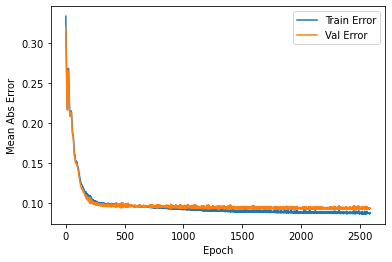

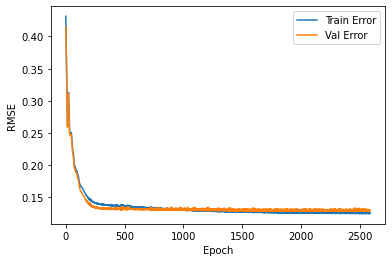

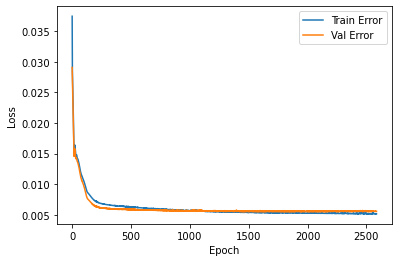

In [65]:
# Fit the Model 
history = model.fit(train_dataset, train_labels,
                    epochs=10000,
                    validation_split = 0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=4096,
                    callbacks=[early_stop,PrintDot()])
print('\n')

# Display the training history
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.plot(hist['epoch'], np.sqrt(hist['mean_squared_error']),label='Train Error')
  plt.plot(hist['epoch'], np.sqrt(hist['val_mean_squared_error']),label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [67]:
# Save the model
modelName = 'fcModel_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.hd5'
model.save(modelName,save_format='h5')
# Save a TFLite version
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open(modelName.replace('hd5','tflite'), "wb").write(tflite_model)

print('Saved: ',modelName)




#loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)




Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\scart\DOCUME~1\MobaXterm\slash\var\log\xwin\tmpzs_01a8x\assets
Saved:  fcModel_202105172331.hd5


## Prediction Plots

Green RMSE = 0.104129
Non Green RMSE = 0.148749
Bare RMSE = 0.126023
Min Bare = 0.008898
Min Green = 0.002062
Min NonGreen = 0.045694


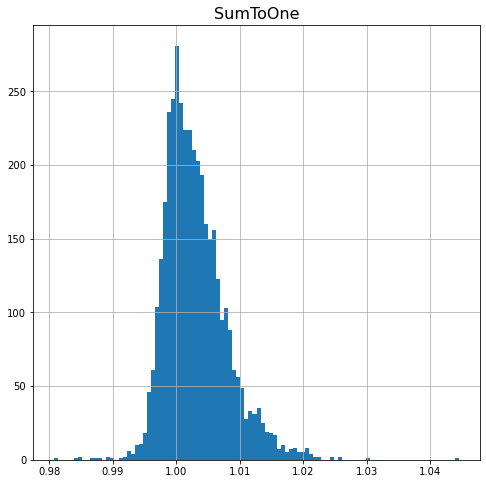

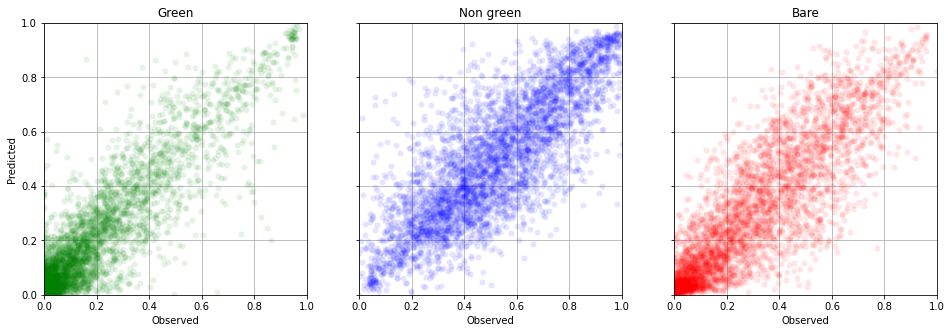

In [66]:
# Predict!
#test_predictions = model.predict(normed_test_data)
allLabels = train_labels
allPredictions = model.predict(train_dataset)

predNongreenCover=allPredictions[:,2]
predGreenCover=allPredictions[:,1]
predBareCover=allPredictions[:,0]
totalSum = predNongreenCover+predGreenCover+predBareCover

# Print some RMSE values
print( "Green RMSE = %f" % np.sqrt(np.mean((totalPVCover-predGreenCover)**2)))
print( "Non Green RMSE = %f" % np.sqrt(np.mean((totalNPVCover-predNongreenCover)**2)))
print( "Bare RMSE = %f" % np.sqrt(np.mean((totalBareCover-predBareCover)**2)))
print( "Min Bare = %f" % np.percentile(predBareCover,1))
print( "Min Green = %f" % np.percentile(predGreenCover,1))
print( "Min NonGreen = %f" % np.percentile(predNongreenCover,1))


# Setup the sum to one histogram
fig = plt.figure(figsize=(8,8))
plt.hist(totalSum, bins=100)
plt.title('SumToOne', fontsize=16)
plt.grid(True)
plt.savefig('fcSum2one.png', bbox_inches='tight')

# Initialise the 1 row 3 column plot for each fraction
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,5),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,predGreenCover, 'go',alpha=0.1,markeredgewidth=0.0)
ax2.plot(totalNPVCover,predNongreenCover, 'bo',alpha=0.1,markeredgewidth=0.0)
ax3.plot(totalBareCover,predBareCover, 'ro',alpha=0.1,markeredgewidth=0.0)
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green')
ax2.set_title('Non green')
ax3.set_title('Bare')
ax1.set_xlabel('Observed')
ax2.set_xlabel('Observed')
ax3.set_xlabel('Observed')
ax1.set_ylabel('Predicted')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
f.savefig('fcCalibration.png', bbox_inches='tight')



## Assess the stability of the model by running cross validation
We use a 50:50 split run 

In [ ]:
refDataGreen = numpy.copy(refData[:,:8]) 
greenEstimator.fit(refDataGreen, logit(totalPVCover))
resultsG = expit(greenEstimator.predict(refDataGreen))

refDataNonGreen = numpy.append(refDataGreen,numpy.transpose([resultsG]),axis=1)
nonGreenEstimator.fit(refDataNonGreen, logit(totalNPVCover))
resultsN = expit(nonGreenEstimator.predict(refDataNonGreen))

refDataBare = numpy.append(refDataNonGreen,numpy.transpose([resultsN]),axis=1)
bareEstimator.fit(refDataBare, logit(totalBareCover))



# TestTrainSplit
trainAmount = .5
iterations = 100

gdbMAD=numpy.zeros((3,iterations))
gdbRMS=numpy.zeros((3,iterations))
numSamples = len(refData)
trainNumber=int(trainAmount * numSamples)

for i in range(iterations):
    #print( iterations - i,)
    randIDX=numpy.random.permutation(range(numSamples))
    trainIDX = randIDX[:trainNumber]
    testIDX = randIDX[trainNumber:]

    greenEstimator.fit(refDataGreen[trainIDX], logit(totalPVCover[trainIDX]))
    resultsG = expit(greenEstimator.predict(refDataGreen[trainIDX]))
    resultsGTest = expit(greenEstimator.predict(refDataGreen[testIDX]))


    gdbMAD[0,i] = numpy.median(numpy.abs(resultsGTest - totalPVCover[testIDX]))
    gdbRMS[0,i] = numpy.sqrt(numpy.mean((resultsGTest - totalPVCover[testIDX])**2.0))

    refDataNonGreenTrain = numpy.append(refDataGreen[trainIDX],numpy.transpose([resultsG]),axis=1)
    refDataNonGreenTest = numpy.append(refDataGreen[testIDX],numpy.transpose([resultsGTest]),axis=1)


    nonGreenEstimator.fit(refDataNonGreenTrain, logit(totalNPVCover[trainIDX]))
    resultsN = expit(nonGreenEstimator.predict(refDataNonGreenTrain))
    resultsNTest = expit(nonGreenEstimator.predict(refDataNonGreenTest))


    gdbMAD[1,i] =  numpy.median(numpy.abs(resultsNTest - totalNPVCover[testIDX]))
    gdbRMS[1,i] = numpy.sqrt(numpy.mean((resultsNTest - totalNPVCover[testIDX])**2.0))

    refDataBareTrain = numpy.append(refDataNonGreen[trainIDX],numpy.transpose([resultsN]),axis=1)
    refDataBareTest = numpy.append(refDataNonGreen[testIDX],numpy.transpose([resultsNTest]),axis=1)


    bareEstimator.fit(refDataBareTrain, logit(totalBareCover[trainIDX]))
    resultsB = expit(bareEstimator.predict(refDataBareTrain))
    resultsBTest = expit(bareEstimator.predict(refDataBareTest))

    gdbMAD[2,i] = numpy.median(numpy.abs(resultsBTest - totalBareCover[testIDX]))
    gdbRMS[2,i] = numpy.sqrt(numpy.mean((resultsBTest - totalBareCover[testIDX])**2.0))






In [ ]:
fig = plt.figure(figsize=(10,10))
plt.hist(gdbMAD[0], bins=100, color="green", range=(0.0,0.2) )
plt.hist(gdbMAD[1], bins=100, color="blue", range=(0.0,0.2) )
plt.hist(gdbMAD[2], bins=100, color="red", range=(0.0,0.2) )
plt.title('Cross Validated Median Absolute Error', fontsize=16)
plt.grid(True)
plt.savefig('madError.png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.hist(gdbRMS[0], bins=100, color="green", range=(0.0,0.2))
plt.hist(gdbRMS[1], bins=100, color="blue", range=(0.0,0.2) )
plt.hist(gdbRMS[2], bins=100, color="red", range=(0.0,0.2) )
plt.title('Cross Validated Root Mean Square Error', fontsize=16)
plt.grid(True)
plt.savefig('rmsError.png', bbox_inches='tight')

## And check that the model runs!

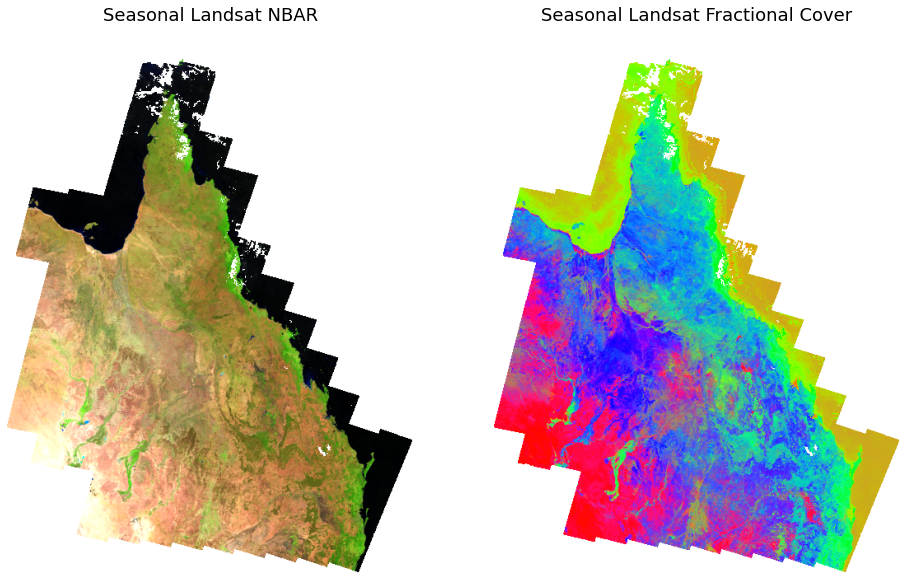

In [68]:
import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# The unmixing model
def unmixfc(nbar, fcModel):
    # Get the shape of the input array
    inshape = nbar.shape
    # Flatten and scale reflectance
    nbar = np.reshape(nbar,(inshape[0],-1)) / 10000.0

    # Convert Landsat 8 if required
    nbar = np.transpose(np.transpose(nbar) * 
                        np.array([0.97470, 0.99779, 1.00446, 0.98906, 0.99467, 1.02551]) + 
                        np.array([0.00041, 0.00289, 0.00274, 0.00004, 0.00256, -0.00327]))

    # Convert Sentinel 2 if required
    #nbar = np.transpose(np.transpose(nbar[[0,1,2,3,8,9]]) * 
    #                   np.array([0.9551, 1.0582, 0.9871, 1.0187, 0.9528, 0.9688]) + 
    #                  np.array([-0.0022, 0.0031, 0.0064, 0.012, 0.0079, -0.0042]))

    # Drop the Blue band. Blue is yukky
    refData = np.transpose(nbar[1:])

    # Run the prediction
    fcLayers = np.clip(fcModel.predict(refData)[:,0:3].T,0,2)
    fcLayerSum = fcLayers.sum(axis=0) + np.finfo('float32').eps
    # Clip Output
    outputFC = np.round(100 * fcLayers/fcLayerSum, 0)
    # Correct noData
    outputFC[:,nbar[0] < 0.001] = 255
    outputFC[:,nbar[0] > 0.999] = 255
    # Reshape the FC Output
    return np.reshape(outputFC,(3,inshape[1],inshape[2])).astype(np.uint8),fcLayers


# Connect to the seasonal surface reflectance
dataPath = '/vsicurl/http://qld.auscover.org.au/public/data/landsat/surface_reflectance/qld/l8olre_qld_m201906201908_dbia2.tif'
# Open the data set
refDataSet = rasterio.open(dataPath)
# Read in the imagery at an overview level
overviewLevel = 128
refData = np.ma.masked_equal(refDataSet.read(
    out_shape=(refDataSet.count,
               int(refDataSet.height / overviewLevel),
               int(refDataSet.width / overviewLevel))),
               refDataSet.nodatavals[0])

# Run the prediction
fcModel = tf.keras.models.load_model(modelName,compile=False)
fcImage,fcLayers = unmixfc(refData,fcModel)

# Plot the images
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,16),sharey=True)
# Plot the three fractions
ax1.imshow(
    np.rollaxis(
        np.clip(refData[[4,3,2]] / 4000.0 * 255.0, 0, 255)
        .astype('uint8')
        ,0,3)
    , aspect=1)
ax1.set_title('Seasonal Landsat NBAR', fontsize=18)
ax1.axis('off');

ax2.imshow(
    np.rollaxis(
        np.clip(fcImage / 100.0 * 400.0, 0, 255)
        .astype('uint8')
        ,0,3)
    , aspect=1)
ax2.set_title('Seasonal Landsat Fractional Cover', fontsize=18)
ax2.axis('off');

f.savefig('fcPredictions.png', bbox_inches='tight')


## Crypto Analysis